In [1]:
import os
import abc
from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

np.random.seed(int.from_bytes(os.urandom(4), byteorder="big"))

In [2]:
class PoissonProcess(abc.ABC):
    @abc.abstractmethod
    def generate_series(self, t: float) -> pd.Series:
        pass

In [3]:
class HomogenousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float):
        self.lambda_: float = lambda_

    def generate_series(self, t: float) -> pd.Series:
        t_ = 0
        s = []
        while True:
            u = np.random.uniform()
            t_ = t_ - 1 / self.lambda_ * np.log(u)
            if t_ > t:
                break
            s.append(t_)
        s = pd.Series(s)
        return s

In [4]:
class InhomogeneousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float, lambda_t: Callable[[float], float]):
        self.lambda_: float = lambda_
        self.lambda_t: Callable[[float], float] = lambda_t

    def generate_series(self, t: float) -> pd.Series:
        t_ = 0
        s = []
        while True:
            u1 = np.random.uniform()
            t_ = t_ - 1 / self.lambda_ * np.log(u1)
            if t_ > t:
                break
            u2 = np.random.uniform()
            if u2 <= self.lambda_t(t_) / self.lambda_:
                s.append(t_)
        s = pd.Series(s)
        return s

In [5]:
class RandomVariable(abc.ABC):
    @abc.abstractmethod
    def generate(self) -> float | int:
        pass

    def generate_series(self, n: int) -> pd.Series:
        return pd.Series([self.generate() for _ in range(n)])

In [6]:
class ExponentialRandomVariable(RandomVariable):
    def __init__(self, lambda_: float):
        self.lambda_: float = lambda_

    def generate(self) -> float:
        u = np.random.uniform(0, 1)
        return -1 / self.lambda_ * np.log(1 - u)

In [7]:
@np.vectorize
def exp_prob(lambda_: float, start: float, end: float) -> float:
    return np.exp(-lambda_ * start) - np.exp(-lambda_ * end)

def chi2_exp(bins: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    values = (bins[1:] + bins[:-1]) / 2
    x_b = np.sum(values * counts) / n
    lambda_s = 1 / x_b
    p = exp_prob(lambda_s, bins[:-1], bins[1:])
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).set_index('i', drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

def chi2_test(pp: PoissonProcess, alpha: float, t: float):
    inc = pp.generate_series(t).to_numpy()
    display(inc)
    intervals = inc[1:] - inc[:-1]

    b = np.linspace(np.floor(intervals.min()), np.ceil(intervals.max()), int(1 + np.log2(len(intervals))))
    c, _ = np.histogram(intervals, bins=b)

    display(b)
    display(c)
    plt.stairs(c, b)

    chi2, df, t = chi2_exp(b.copy(), c.copy())
    display(t)

    chi2_crit = scipy.stats.chi2.isf(alpha, df=df, loc=0, scale=1)

    dft = pd.DataFrame.from_dict({
        "df": df,
        "chi2": chi2,
        "chi2_crit": chi2_crit,
        "H0": "принимаем" if chi2 < chi2_crit else "отвергаем"
    }, orient="index")
    display(dft)

In [8]:
T = 100
POISSON_LAMBDA = 1
POISSON_LAMBDA_T = lambda t: 1 + 1 / np.sqrt(t)
ALPHA = 0.05

In [9]:
hpp = HomogenousPoissonProcess(POISSON_LAMBDA)

array([ 1.67393923,  2.97610599,  3.40615884,  4.30376483,  4.32283669,
        4.40653048,  6.20411721,  6.36873803,  7.72241423, 10.7237638 ,
       11.43880647, 12.82919383, 12.98878066, 14.94208401, 15.45648327,
       15.76247482, 15.85287625, 16.16954223, 16.71540595, 18.22714828,
       18.38952637, 19.37796475, 19.79896333, 21.86691218, 22.05486946,
       25.5099185 , 26.05241055, 26.62029894, 28.52509989, 29.7148273 ,
       30.04661805, 32.6190244 , 33.46225895, 34.76564172, 36.12463437,
       36.89912632, 36.91064624, 37.38340806, 38.63779604, 39.39735637,
       39.59928887, 41.31475684, 42.14034215, 42.16188828, 44.11372397,
       47.28954737, 48.15649747, 49.0433057 , 51.26557912, 52.61078863,
       53.73636518, 53.83009609, 55.0446291 , 58.54703516, 60.58225402,
       61.56745544, 62.5309528 , 62.72835655, 62.74979198, 63.28585841,
       63.6418544 , 63.75027661, 63.89725302, 65.63664274, 66.97435478,
       68.91551987, 71.66588931, 72.17142691, 73.19952835, 74.18

array([0.        , 0.66666667, 1.33333333, 2.        , 2.66666667,
       3.33333333, 4.        ])

array([46, 25, 19,  5,  3,  2])

,n_i,n'_i,n_i - n'_i,(n_i - n'_i)^2,K
i,,,,,
0.333333,46,48.658288,-2.658288,7.066496,0.145227
1.000000,25,24.981998,0.018002,0.000324,0.000013
1.666667,19,12.826185,6.173815,38.115986,2.971732
2.333333,5,6.585183,-1.585183,2.512806,0.381585
3.000000,3,3.380946,-0.380946,0.145120,0.042923
3.666667,2,1.735835,0.264165,0.069783,0.040201


,0
df,4
chi2,3.581681
chi2_crit,9.487729
H0,принимаем


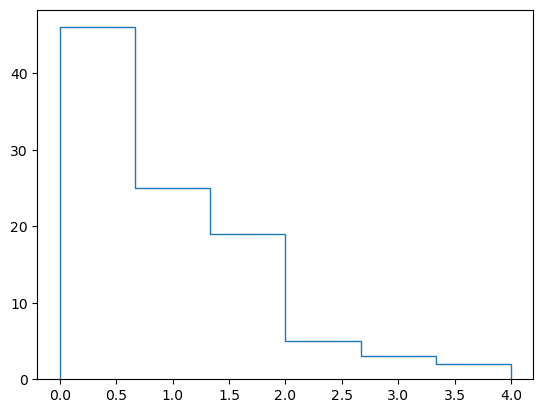

In [10]:
chi2_test(hpp, ALPHA, T)

In [11]:
ipp = InhomogeneousPoissonProcess(POISSON_LAMBDA, POISSON_LAMBDA_T)

In [21]:
hpp.generate_series(10)

0    0.082784
1    1.331946
2    1.901004
3    4.032374
4    4.622639
5    4.910795
6    5.290326
7    7.181454
8    8.868396
9    9.927527
dtype: float64

In [13]:
EXP_LAMBDA = 1

In [14]:
erv = ExponentialRandomVariable(EXP_LAMBDA)

In [15]:
def simulate_mss(t: float, incoming_proc: PoissonProcess, process_func: RandomVariable) -> pd.DataFrame:
    incoming = incoming_proc.generate_series(t)
    processing = process_func.generate_series(len(incoming))
    raw_ending = [incoming[0] + processing[0]]
    raw_starting = [incoming[0]]
    for i in range(1, len(incoming)):
        if incoming[i] >= raw_ending[i-1]:
            raw_ending.append(incoming[i] + processing[i])
            raw_starting.append(incoming[i])
        else:
            raw_ending.append(raw_ending[i-1] + processing[i])
            raw_starting.append(raw_ending[i-1])
    df = pd.DataFrame({
        "incoming": incoming,
        "starting": raw_starting,
        "processing": processing,
        "ending": raw_ending
    })
    df.index += 1
    return df

In [16]:
mss = simulate_mss(10, hpp, erv)
display(mss)

,incoming,starting,processing,ending
1,0.521395,0.521395,2.528559,3.049953
2,2.754354,3.049953,0.115675,3.165628
3,2.938716,3.165628,0.692283,3.857911
4,4.834087,4.834087,1.755694,6.589781
5,6.416539,6.589781,0.902498,7.492279
6,7.323421,7.492279,0.761132,8.253411
7,7.427359,8.253411,1.392769,9.646181
8,9.280971,9.646181,1.234111,10.880291
9,9.374446,10.880291,1.585622,12.465914
10,9.903401,12.465914,0.821640,13.287553
